In [49]:
import pandas as pd
import ast
import numpy as np
import tqdm
import random
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

import itertools
from itertools import combinations, product

import scipy
from scipy.spatial.distance import cdist

import gensim
from gensim.models import Word2Vec, FastText

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn import __version__ as sklearn_version

import prep_data_functions
import embeddings_functions

import warnings

In [50]:
package_versions = {
    "pandas": pd.__version__,
    "matplotlib": matplotlib.__version__,
    "numpy": np.__version__,
    "tqdm": tqdm.__version__,
    "seaborn": sns.__version__,
    "scipy": scipy.__version__,
    "gensim": gensim.__version__,
    "sklearn": sklearn_version,
}
for package, version in package_versions.items():
    if version is None:
        print(f"{package}: Standard library module (no version)")
    else:
        print(f"{package}: {version}")

pandas: 2.1.4
matplotlib: 3.5.2
numpy: 1.23.0
tqdm: 4.65.2
seaborn: 0.13.2
scipy: 1.8.1
gensim: 4.2.0
sklearn: 1.5.1


In [51]:
warnings.filterwarnings('ignore')
gensim.models.keyedvectors.logger.setLevel(50)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="gensim.models.keyedvectors")
sns.set(style="whitegrid")

# Experiment 1 

In [52]:
num_documents_values = [10, 50, 200, 500]
vector_sizes = [2, 300]

## Random generator inicialization

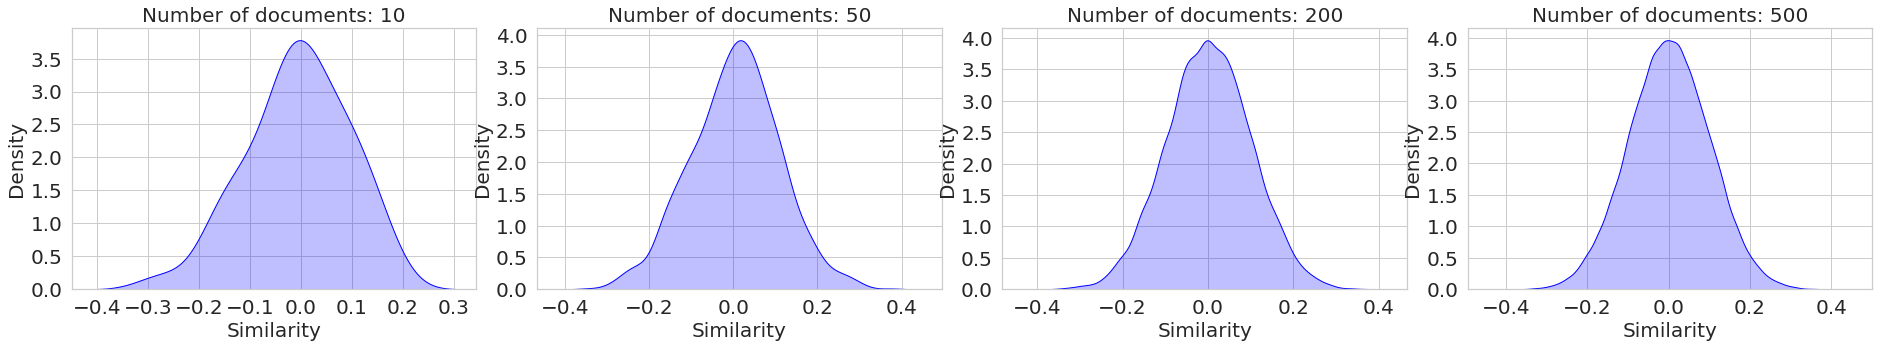

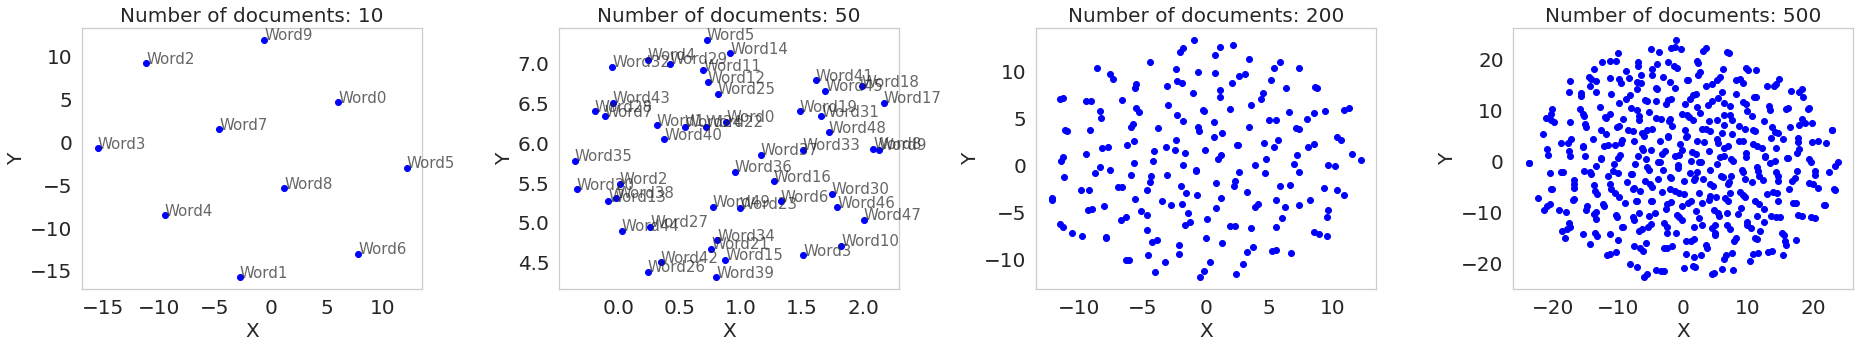

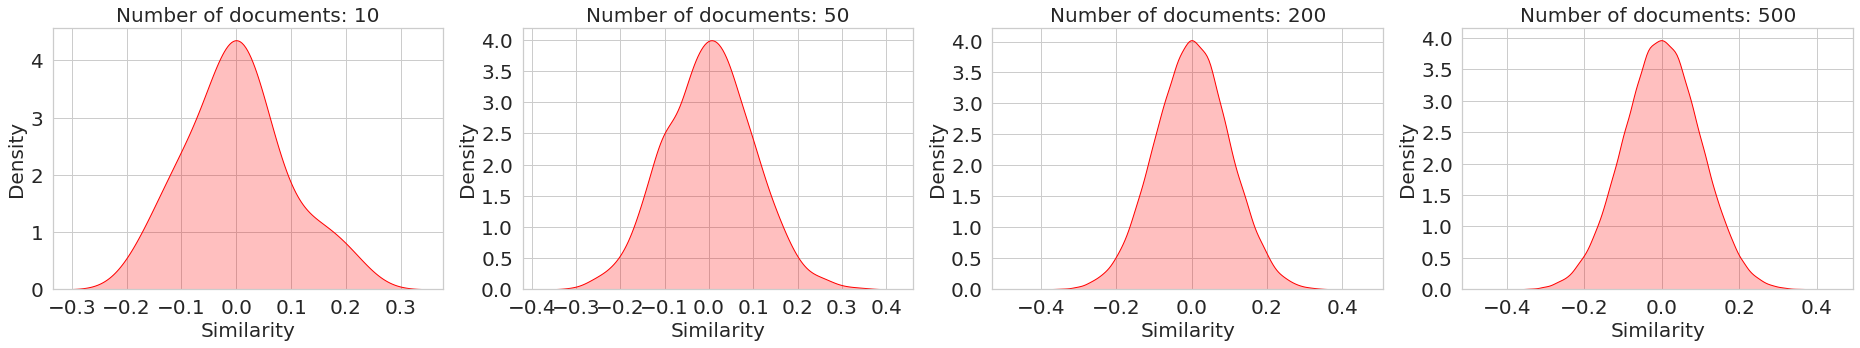

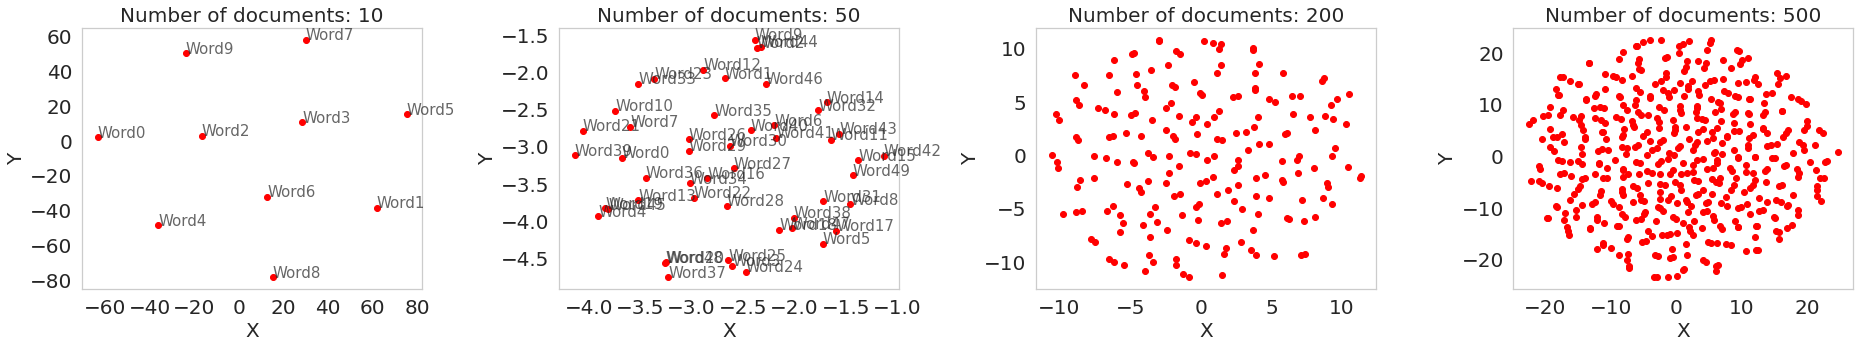

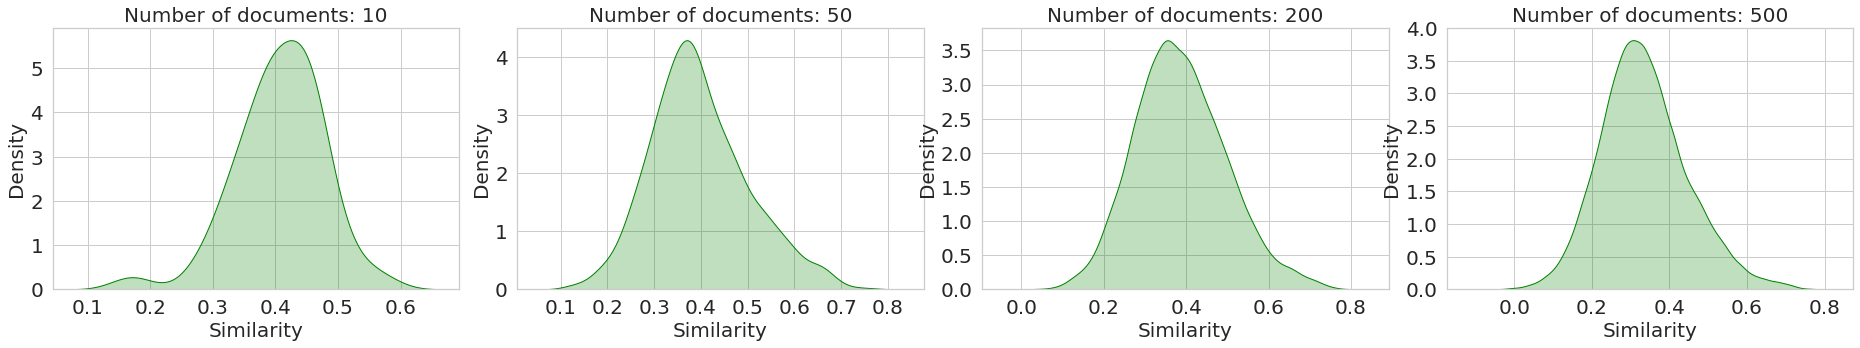

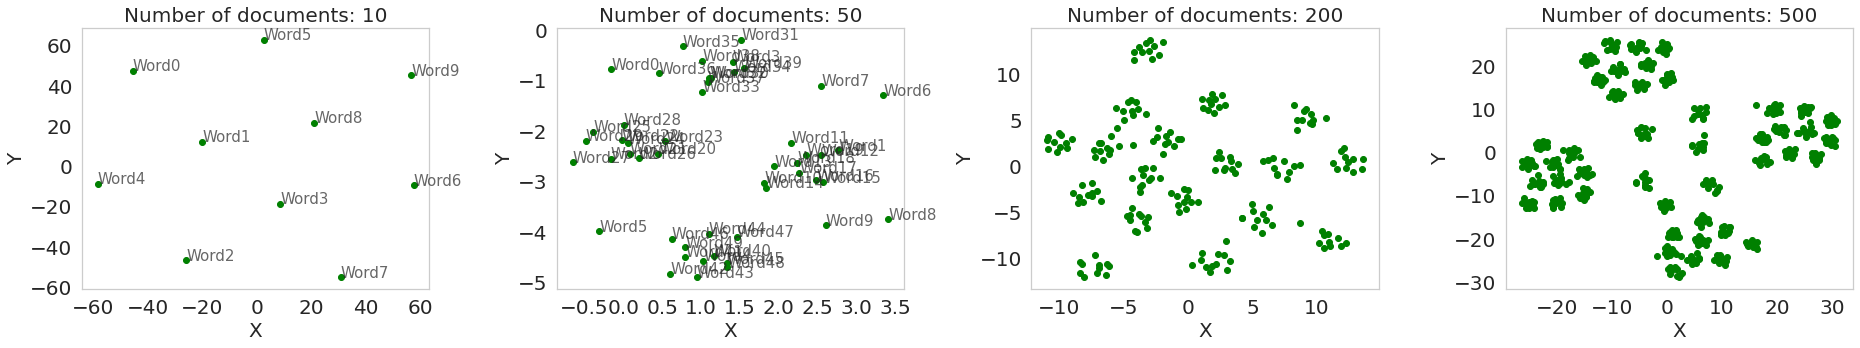

In [53]:
def pseudorandom_weak_vector(size=100, seed_string=None, hashfxn=hash):
    """Get a random vector, derived deterministically from `seed_string` if supplied.
    Useful for initializing KeyedVectors that will be the starting projection/input layers of _2Vec models.
    """
    if seed_string:
        once = np.random.Generator(np.random.SFC64(hashfxn(seed_string) & 0xffffffff))
    else:
        once = np.random.default_rng()
    vector = (once.random(size).astype(np.float32) - 0.5) / size
    normalized_vector = normalize([vector], norm='l2')
    return normalized_vector[0]

def generate_corpus(num_documents):
    document_length = 1
    return [["Word" + str(k)] for k in range(num_documents)]

def create_word_embeddings(corpus, words, embedding_type="pseudorandom"):
    vector_size = 100  # Pevná velikost vektoru
    if embedding_type == "pseudorandom":
        return pd.DataFrame([pseudorandom_weak_vector(vector_size) for _ in range(len(words))], index=words)
    elif embedding_type == "word2vec":
        word_embeddings = embeddings_functions.Word2VecEmbeddings(corpus, "E1")
        return word_embeddings.train_and_get_emb(words=words, window=1, min_count=1, seed=1, sg=1, vector_size=vector_size, norm=True, epochs=4)
    elif embedding_type == "fasttext":
        word_embeddings = embeddings_functions.FastTextEmbeddings(corpus, "E1")
        return word_embeddings.train_and_get_emb(words=words, window=1, min_count=1, seed=1, sg=1, vector_size=vector_size, norm=True, epochs=4)

def plot_similarity(df_cosine, num_documents, subplot_idx, color):
    ax = plt.subplot(1, len(num_documents_values), subplot_idx)
    sns.kdeplot(df_cosine["similarity"], color=color, label="Cosine Similarity", fill=True)
    plt.xlabel("Similarity", fontsize=25)
    plt.ylabel("Density", fontsize=25)
    plt.title(f"Number of documents: {num_documents}", fontsize=30)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

def plot_embeddings(embeddings, words, num_documents, subplot_idx, color):
    ax = plt.subplot(1, len(num_documents_values), subplot_idx)
    embedding_array = embeddings.values
    num_dimensions = embedding_array.shape[1]

    if num_dimensions == 2:
        x = embedding_array[:, 0]
        y = embedding_array[:, 1]
        plt.scatter(x, y, color=color)
        plt.xlabel("X", fontsize=20)
        plt.ylabel("Y", fontsize=20)

        plt.title(f"Number of documents: {num_documents}", fontsize=20)
        
        # Nastavení rozmezí os (přidání marginu)
        margin = 0.05  # například 5 % navíc
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        ax.set_xlim([x_min - margin * (x_max - x_min), x_max + margin * (x_max - x_min)])
        ax.set_ylim([y_min - margin * (y_max - y_min), y_max + margin * (y_max - y_min)])
        
        
        if num_documents <= 50:
            for k, word in enumerate(embeddings.index):
                clean_word = word.replace("Word", "")  # Odstranění "Word" z popisku
                plt.annotate(clean_word, (x[k], y[k]), alpha=0.7, fontsize=20)
    else:
        perplexity = min(30, len(words) - 1)
        tsne_model = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        tsne_embeddings = tsne_model.fit_transform(embedding_array)
        x = tsne_embeddings[:, 0]
        y = tsne_embeddings[:, 1]
        plt.scatter(x, y, color=color)
        plt.xlabel("X", fontsize=20)
        plt.ylabel("Y", fontsize=20)
        
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.grid(False) 
    
        plt.title(f"Number of documents: {num_documents}", fontsize=20)
        if num_documents <= 50:
            for k, word in enumerate(embeddings.index):
                plt.annotate(word, (x[k], y[k]), alpha=0.7, fontsize=15)

def run_experiment(num_documents_values, embedding_type, plot_type, color):
    plt.figure(figsize=(26, 5))
    for j, num_documents in enumerate(num_documents_values):
        corpus = generate_corpus(num_documents)
        words = np.array(corpus)[:, 0]
        embeddings = create_word_embeddings(corpus, words, embedding_type)
        #print(f"Experiment: num_documents={num_documents} - train is done")
        subplot_idx = j + 1
        if plot_type == "similarity":
            similarity = embeddings_functions.Similarity2(embeddings_df=embeddings)
            df_cosine = similarity.get_cosine_similarity_of_all_words()
            plot_similarity(df_cosine, num_documents, subplot_idx, color)
        elif plot_type == "embedding":
            plot_embeddings(embeddings, words, num_documents, subplot_idx, color)
    plt.subplots_adjust(hspace=0.6, wspace=0.6, left=0.3, right=0.9, bottom=0.3, top=0.7)
    plt.savefig(f'{embedding_type}_{plot_type}.pdf', bbox_inches='tight', pad_inches=0.1)
    plt.tight_layout()
    plt.show()

# Define your number of documents values
num_documents_values = [10, 50, 200, 500]  # Example number of documents values

# Run the experiment for different embedding types and plot types
run_experiment(num_documents_values, "pseudorandom", "similarity", "blue")
run_experiment(num_documents_values, "pseudorandom", "embedding", "blue")
run_experiment(num_documents_values, "word2vec", "similarity", "red")
run_experiment(num_documents_values, "word2vec", "embedding", "red")
run_experiment(num_documents_values, "fasttext", "similarity", "green")
run_experiment(num_documents_values, "fasttext", "embedding", "green")

## E2

In [64]:
def prepare_corpus(num_documents, document_length):
    experimental = prep_data_functions.ExperimentalDF(num_documents=num_documents, document_length=document_length)
    corpus2_df = experimental.define_first_df()
    return experimental, corpus2_df

def split_documents(corpus2_df):
    np.random.seed(3)
    docs = list(set(corpus2_df.Document.values))
    np.random.shuffle(docs)
    half_len = len(docs) // 2
    return docs[:half_len], docs[half_len:]

def prepare_train_test_data(experimental, corpus2_df, train_docs, test_docs):
    words_from_train = corpus2_df[corpus2_df["Document"].isin(train_docs)]
    df_train = experimental.aggregate_documents(words_from_train)
    df_train = experimental.tokenize_data('document', df_train)

    words_from_test = corpus2_df[corpus2_df["Document"].isin(test_docs)]
    df_test = experimental.aggregate_documents(words_from_test)
    df_test = experimental.tokenize_data('document', df_test)

    return df_train, df_test

def generate_combinations(corpus2_df):
    df1 = pd.DataFrame(corpus2_df)
    combinations_list = list(product(df1['Word'], repeat=2))
    df2 = pd.DataFrame(combinations_list, columns=['Word1', 'Word2'])
    df2['Document1'] = df2['Word1'].map(df1.set_index('Word')['Document'])
    df2['Document2'] = df2['Word2'].map(df1.set_index('Word')['Document'])
    df2 = df2[df2["Document1"] != df2["Document2"]]
    df2 = df2[["Word1", "Word2"]]
    df2.columns = ["First", "Last"]
    return df2

def get_unique_pairs(df_train, df_test):
    unique_pairs_train = pd.DataFrame(df_train, columns=['First', "Middle", 'Last']).drop_duplicates()
    unique_pairs_test = pd.DataFrame(df_test, columns=['First', "Middle", 'Last']).drop_duplicates()

    for df in [unique_pairs_train, unique_pairs_test]:
        df["join_middle_first"] = df["First"] + df["Middle"]
        df["join_middle_last"] = df["Middle"] + df["Last"]
        df["join_first_last"] = df["First"] + df["Last"]

    return unique_pairs_train, unique_pairs_test

def plot_results(avg_train_list, avg_test_list, avg_df2_list, corpus_size):
    plt.figure(figsize=(6, 6))
    plt.plot(corpus_size,avg_train_list, label='Words once appeared in same context')
    plt.plot(corpus_size,avg_test_list, label='Words frequently appeared together')
    plt.plot(corpus_size,avg_df2_list, label='Words never appeared together')
    plt.legend()
    plt.show()
    
    
def plot_results_sim(similarity_scores_train, similarity_scores_test, similarity_scores_df2):
    x_values = [i / 10 for i in range(11)]  # Create x values from 0 to 1 with increments of 0.1

    plt.figure(figsize=(18, 6))

    # First plot without grid and with a smoothed density plot
    plt.subplot(1, 3, 1)
    sns.kdeplot(np.array(similarity_scores_train), color='blue', fill=True, alpha=0.7)
    plt.title('Words once appeared in same context', fontsize=18)
    plt.xlim(0, 1)
    plt.xticks(x_values, fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Density', fontsize=18)
    plt.grid(False)

    # Second plot without grid and with a smoothed density plot
    plt.subplot(1, 3, 2)
    sns.kdeplot(np.array(similarity_scores_test), color='green', fill=True, alpha=0.7)
    plt.title('Words frequently appeared together', fontsize=18)
    plt.xlim(0, 1)
    plt.xticks(x_values, fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Density', fontsize=18)
    plt.grid(False)

    # Third plot without grid and with a smoothed density plot
    plt.subplot(1, 3, 3)
    sns.kdeplot(np.array(similarity_scores_df2), color='red', fill=True, alpha=0.7)
    plt.title('Words never appeared together', fontsize=18)
    plt.xlim(0, 1)
    plt.xticks(x_values, fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Density', fontsize=18)
    plt.grid(False)

    plt.tight_layout()
    plt.show()


def get_similarity_list(df_cosine, unique_pairs):
    sim_vals_1 = df_cosine.merge(unique_pairs, on=['join_middle_first'], how='inner')["similarity"].tolist()
    sim_vals_2 = df_cosine.merge(unique_pairs, on=['join_middle_last'], how='inner')["similarity"].tolist()
    return sim_vals_1 + sim_vals_2


def main_experiment(embedding_model):
    document_length = 3
    experimental, corpus2_df = prepare_corpus(num_documents=30, document_length=document_length)
    train_docs, test_docs = split_documents(corpus2_df)
    df_train, df_test = prepare_train_test_data(experimental, corpus2_df, train_docs, test_docs)
    df2 = generate_combinations(corpus2_df)
    unique_pairs_train, unique_pairs_test = get_unique_pairs(df_train, df_test)
    
    test_docs_indexes = [int(test_docs[item].split("c")[1]) for item in range(len(test_docs))]

    avg_train_list = []
    avg_test_list = []
    avg_df2_list = []
    corpus_size_dupl = []
    corpus_size = []

    similarity_scores_train = []
    similarity_scores_test = []
    similarity_scores_df2 = []

    for cnt_of_dupl in tqdm.tqdm(list(range(1, 25000, 1000))):
        dict_index_count = {test_docs_indexes[item]: cnt_of_dupl for item in range(len(test_docs_indexes))}
        corpus_size_dupl.append(cnt_of_dupl)
        corpus_pokus_t = experimental.create_experiment(dict_index_count=dict_index_count, df=corpus2_df)
        corpus_size.append(len(corpus_pokus_t))
        
        if embedding_model == "Word2Vec":
            word_embeddings = embeddings_functions.Word2VecEmbeddings(corpus_pokus_t, "experiment2")
        elif embedding_model == "FastText":
            word_embeddings = embeddings_functions.FastTextEmbeddings(corpus_pokus_t, "experiment2_ft")
        else:
            raise ValueError("Unsupported embedding model")
        
        words = list(np.array(corpus_pokus_t).ravel())
        embeddings = word_embeddings.train_and_get_emb(words=words, window=1, min_count=1, seed=1, sg=1, vector_size=100, epochs=5, norm=True)
        similarity = embeddings_functions.Similarity2(embeddings_df=embeddings)
        df_cosine = similarity.get_cosine_similarity_of_all_words()

        df_cosine["join_middle_first"] = df_cosine["First"] + df_cosine["Last"]
        df_cosine["join_middle_last"] = df_cosine["First"] + df_cosine["Last"]
        df_cosine["join_first_last"] = df_cosine["First"] + df_cosine["Last"]

        sim_list_train = get_similarity_list(df_cosine, unique_pairs_train)
        sim_list_test = get_similarity_list(df_cosine, unique_pairs_test)

        avg_train_list.append(np.average(sim_list_train))
        avg_test_list.append(np.average(sim_list_test))
        avg_df2_list.append(np.average(df_cosine.merge(df2, on=["First", "Last"])["similarity"].tolist()))
        
        if cnt_of_dupl in [2001, 9001, 15001, 24001]:
            plot_results_sim(sim_list_train, sim_list_test, df_cosine.merge(df2, on=["First", "Last"])["similarity"].tolist())
        
    plot_results(avg_train_list, avg_test_list, avg_df2_list,corpus_size)


  8%|▊         | 2/25 [00:03<00:44,  1.93s/it]

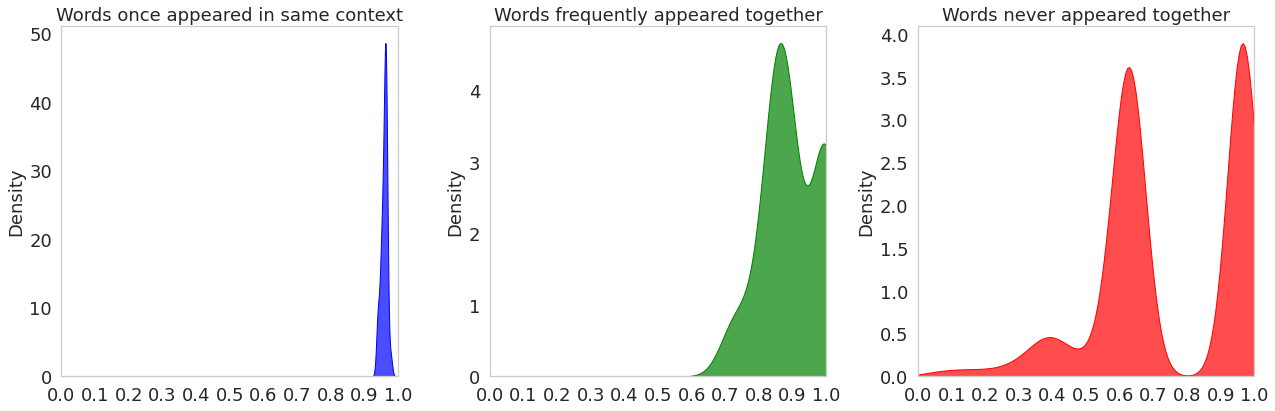

 36%|███▌      | 9/25 [05:25<16:29, 61.83s/it]

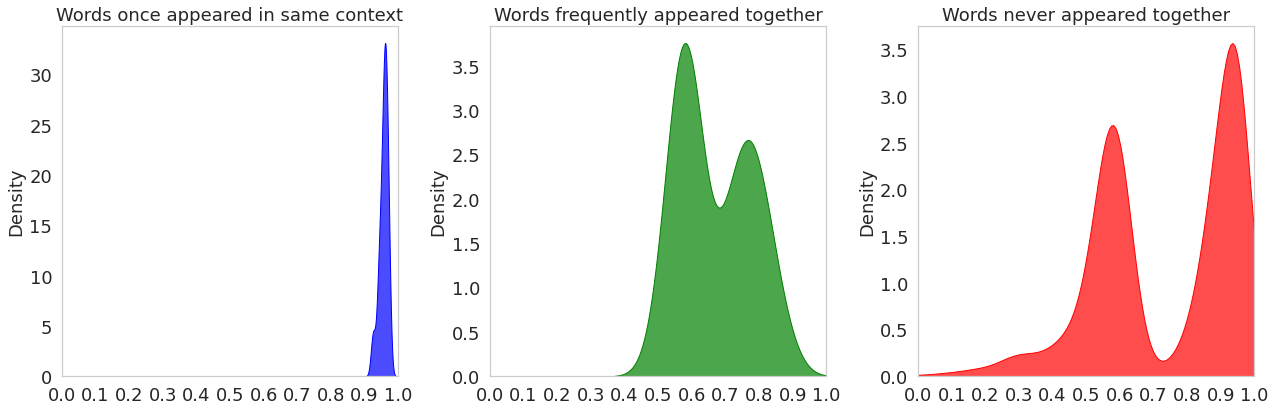

 60%|██████    | 15/25 [24:21<33:28, 200.81s/it]

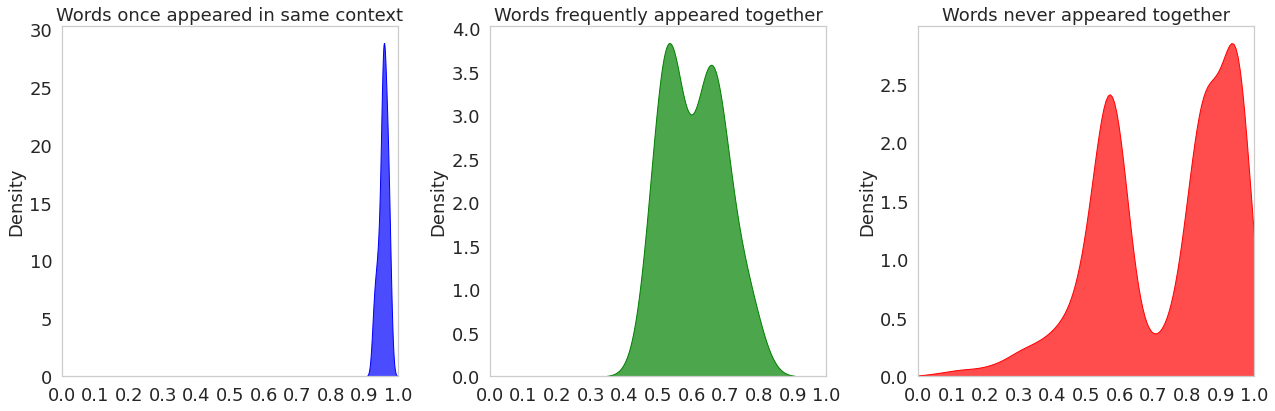

 96%|█████████▌| 24/25 [1:41:08<10:18, 618.58s/it]

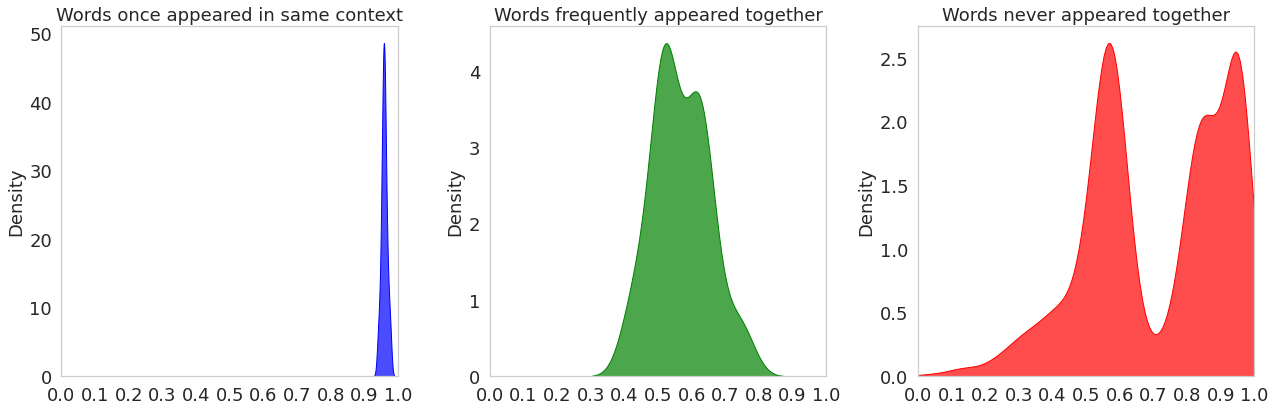

100%|██████████| 25/25 [1:54:57<00:00, 275.89s/it]


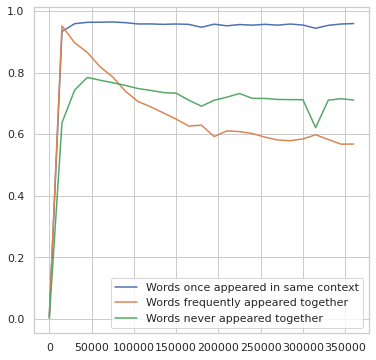

In [65]:
main_experiment(embedding_model="Word2Vec")

  8%|▊         | 2/25 [00:05<01:13,  3.20s/it]

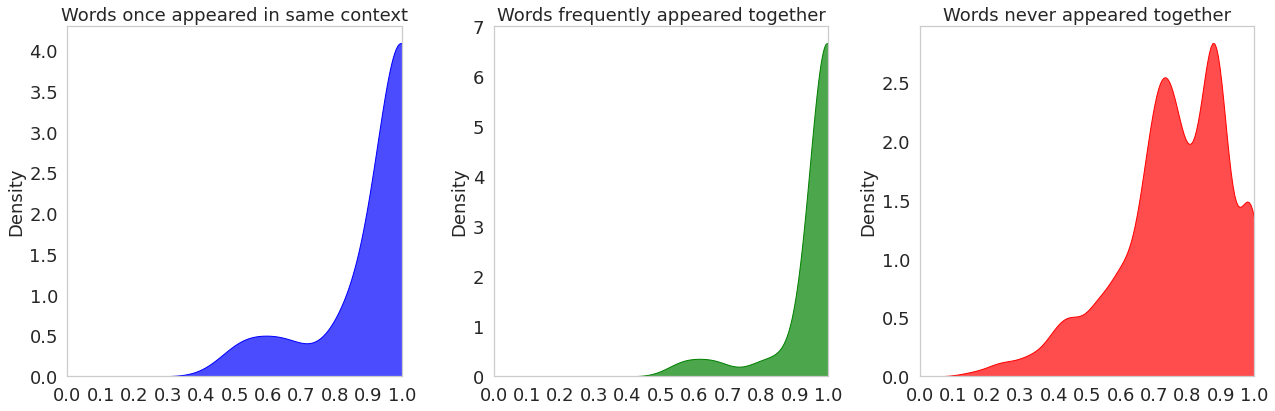

 36%|███▌      | 9/25 [05:28<16:40, 62.56s/it]

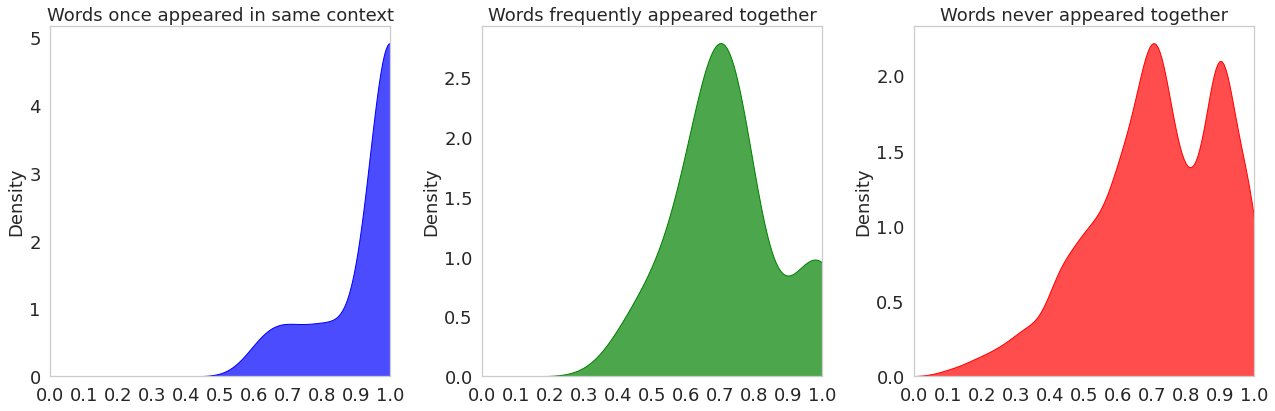

 60%|██████    | 15/25 [24:16<33:31, 201.13s/it]

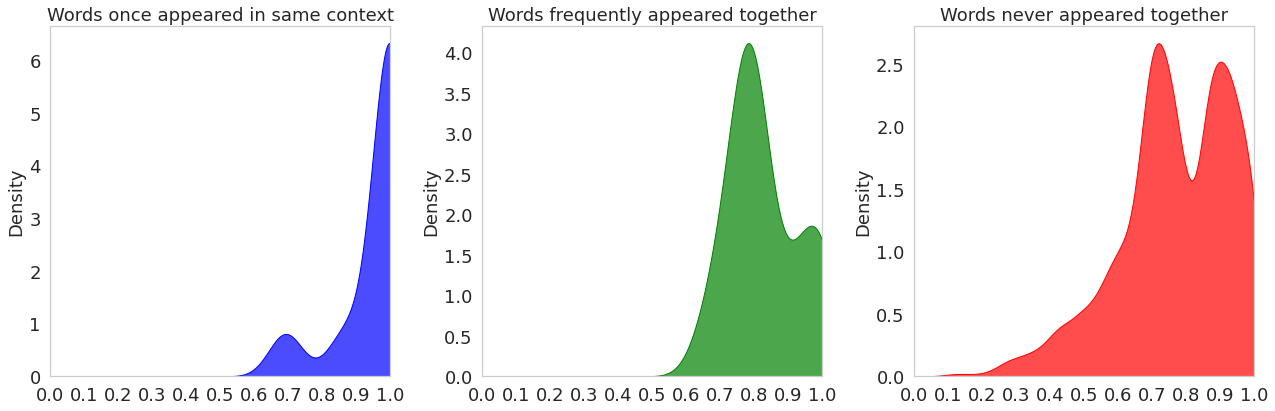

 96%|█████████▌| 24/25 [1:41:45<10:19, 619.70s/it]

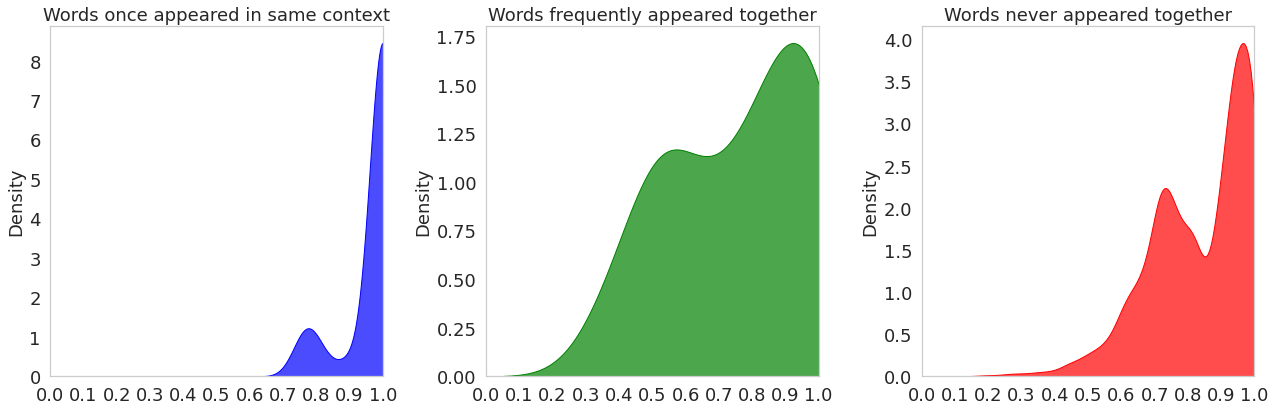

100%|██████████| 25/25 [1:55:52<00:00, 278.08s/it]


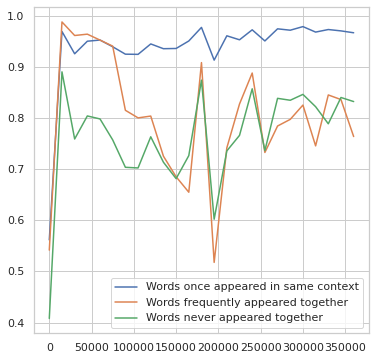

In [66]:
main_experiment(embedding_model="FastText")